<br/>
<br/>

<h1 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u>Modélisation Du Sinistre </u></h1>
<br/>
    

### Entrainement du modèle d'autoencodeur

In [6]:
import numpy as np
import random
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

base_Edu_cleaned est le dataFrame qui a été exporté dans le fichier préparation avant les réductions des dimensions

In [2]:
base_assu= pd.read_parquet("C:/Users/damso/Documents/data/base_assu.parquet")

base_Edu=pd.read_csv("C:/Users/damso/Documents/data/base_Edu_cleaned.csv")

base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(30000)

In [3]:
base_Edu1 = pd.read_parquet("C:/Users/damso/Documents/data/base_Edu.parquet")

columns_delete= list(set(base_Edu1.columns) - set(base_Edu.columns))
len(columns_delete)

104

In [4]:
columns_delete

['time_q75_training_count_avg',
 'serie_q75_exam_score_pct_std_avg',
 'time_q50_training_count_avg',
 'serie_q100_training_score_pct_avg_avg',
 'time_q100_training_score_pct_std_avg',
 'serie_q75_exam_score_pct_avg_avg',
 'avg_correct_answer_rate_last_7d_before_theory_exam',
 'score_at_registration',
 'time_q25_exam_score_pct_std_avg',
 'nb_distinct_instructor',
 'time_q50_theme_count_avg',
 'delay_booking_creation_annulation_days_min',
 'delay_annulation_lesson_days_max',
 'time_q75_exam_count_avg',
 'time_q100_exam_score_pct_std_avg',
 'time_q75_training_score_pct_avg_avg',
 'proportion_activities_last_3d_before_theory_exam',
 'time_q100_theme_score_pct_avg_avg',
 'nb_cancellations',
 'serie_q25_training_score_pct_std_avg',
 'serie_q100_exam_score_pct_avg_avg',
 'serie_q100_theme_score_pct_avg_avg',
 'time_q50_theme_score_pct_std_avg',
 'time_q75_exam_score_pct_std_avg',
 'delay_between_lesson_hours_max',
 'serie_q100_theme_score_pct_std_avg',
 'serie_q25_exam_score_pct_avg_avg',
 't

In [5]:


# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
oneencoder = OneHotEncoder(sparse_output=False)
encoded_cats = oneencoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = oneencoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

Epoch 1/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0447 - val_loss: 0.0306
Epoch 2/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0299 - val_loss: 0.0302
Epoch 3/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0295 - val_loss: 0.0298
Epoch 4/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0292 - val_loss: 0.0296
Epoch 5/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0289 - val_loss: 0.0293
Epoch 6/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0287 - val_loss: 0.0291
Epoch 7/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0284 - val_loss: 0.0289
Epoch 8/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0282 - val_loss: 0.0287
Epoch 9/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0281 - val_loss: 0.0286
Epoch 10/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0279 - val_loss: 0.0285
Epoch 11/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0278 - val_loss: 0.0284
Epoch 12/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/st

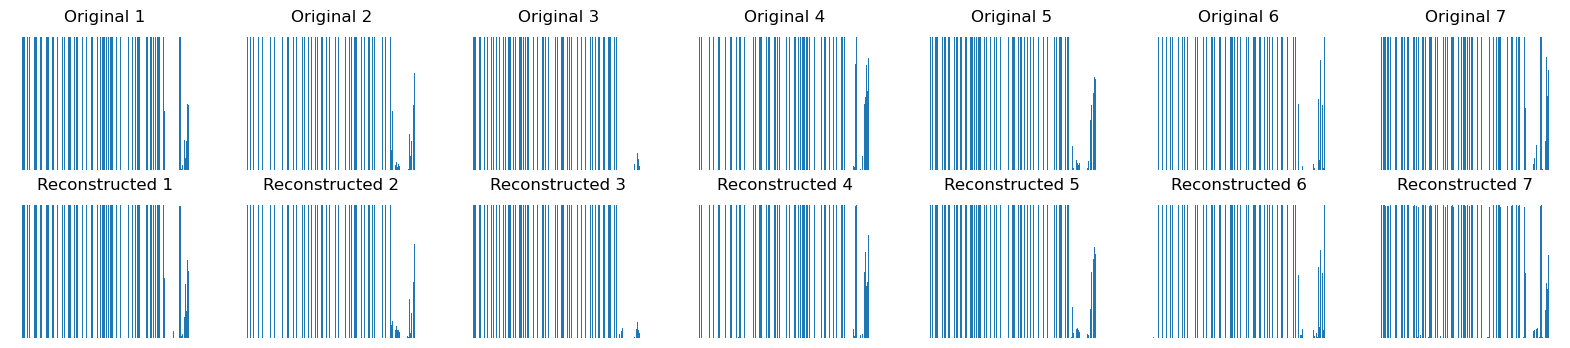

Erreur moyenne de reconstruction : 0.0280


In [33]:
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 3

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

input_img = Input(shape=(input_dim,))
# Encodeur
Hidden1 = Dense(358, activation='relu', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
Hidden_output1 = Dense(358, activation='relu', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")

### importation de la base

In [37]:
#url = "C:/Users/damso/Documents/data/base_Edu.parquet"
df=base_assu
df.describe().T

,count,mean,min,25%,50%,75%,max,std
unique_learner_id,69398.0,3754957169445755.5,-9222849458566410240.0,-4598777253173660672.0,540777374478605.5,4626702790680507392.0,9223326892717478912.0,5329710092417094656.0
learner_id,69398.0,1583879.345644,364.0,728669.5,1497337.5,2308807.0,4457818.0,1001226.659264
days_between_signup_and_first_activity,69398.0,215.312142,0.0,0.0,27.0,269.0,3491.0,369.320062
days_between_order_and_first_activity,69398.0,141.204213,-2304.0,0.0,2.0,139.0,2912.0,338.464838
days_between_first_and_last_activities,69398.0,344.318583,0.0,85.0,241.0,489.0,2959.0,348.980921
...,...,...,...,...,...,...,...,...
var_Assurance11,69398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
var_Assurance12,69398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
var_Assurance13,69398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
var_Assurance14,69398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# restriction de la base Edu aux variables communes aux bases ASU et EDU
# pour voir les variables qui ne sont pas communes aux deux bases dans la base asu 
columns=[] # contient les colonnes communes aux deux bases 
for column in base_Edu1.columns:
    if column in df.columns:
        columns.append(column)
#base_AE=base_AE[columns]
df.drop(columns, axis=1)


,learner_id,job_number,unique_learner_id_1,days_between_signup_and_first_activity_1,days_between_order_and_first_activity_1,days_between_first_and_last_activities_1,chapter_before_success_count_1,serie_before_success_count_1,quiz_before_success_count_1,theory_activities_total_1,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
0,2032674,5952452787,-5911177134761577615,157,157,195,0,0,0,42,...,0,0,0,0,0,0,0,0,0,0
1,893514,6956583814,8022228279541171063,7,8,819,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
2,2858364,1547176297,4508976855497020988,0,-32,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1362204,3464728867,2395000730355774468,0,0,376,0,0,0,288,...,0,1,3,0,0,0,0,0,0,0
4,1054230,1534163688,1056703805299986938,64,0,691,0,109,0,156,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,3793717,2234733812,-872146316430440559,0,0,372,0,57,18,193,...,0,0,0,0,0,0,0,0,0,0
69394,2775978,1784701608,-3415706474168471139,109,109,270,0,50,0,51,...,0,0,0,0,0,0,0,0,0,0
69395,2102507,7135995107,-1958338314080661076,672,665,613,0,93,321,603,...,0,0,0,0,0,0,0,0,0,0
69396,2862021,1866260241,-7394860117143701634,113,114,76,0,0,0,120,...,0,0,0,0,0,0,0,0,0,0


In [42]:
#suppression des colonnes doubles
columns_double=df.drop(columns, axis=1).drop(['learner_id',	'job_number','unique_learner_id_1','var_Assurance0', 'var_Assurance1', 'var_Assurance2', 'var_Assurance3',
       'var_Assurance4', 'var_Assurance5', 'var_Assurance6', 'var_Assurance7',
       'var_Assurance8', 'var_Assurance9', 'var_Assurance10',
       'var_Assurance11', 'var_Assurance12', 'var_Assurance13',
       'var_Assurance14', 'var_Assurance15'],axis=1).columns

df=df.drop(columns_double, axis=1)
df.head()

,unique_learner_id,learner_id,job_number,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
0,-5911177134761577615,2032674,5952452787,157,157,195,0,0,0,42,...,0,0,0,0,0,0,0,0,0,0
1,8022228279541171063,893514,6956583814,7,8,819,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
2,4508976855497020988,2858364,1547176297,0,-32,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2395000730355774468,1362204,3464728867,0,0,376,0,0,0,288,...,0,1,3,0,0,0,0,0,0,0
4,1056703805299986938,1054230,1534163688,64,0,691,0,109,0,156,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# supression des lignes doubles
df = df.drop_duplicates()
df.shape

(66692, 489)

In [44]:
df.columns

Index(['unique_learner_id', 'learner_id', 'job_number',
       'days_between_signup_and_first_activity',
       'days_between_order_and_first_activity',
       'days_between_first_and_last_activities',
       'chapter_before_success_count', 'serie_before_success_count',
       'quiz_before_success_count', 'theory_activities_total',
       ...
       'var_Assurance6', 'var_Assurance7', 'var_Assurance8', 'var_Assurance9',
       'var_Assurance10', 'var_Assurance11', 'var_Assurance12',
       'var_Assurance13', 'var_Assurance14', 'var_Assurance15'],
      dtype='object', length=489)

In [45]:
# on supprime les variables qui ont été supprimer dans la base edu, ainsi que les variables inutiles
df_new=df.drop(columns_delete + ["unique_learner_id","learner_id","job_number","first_theory_activity_date",'unique_learner_id_1'], axis=1)


In [46]:
print(df_new.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(df_new.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(df_new.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(df_new.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

24  variables de type int ont des valeurs manquantes
24  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


In [47]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=df_new.select_dtypes("boolean").columns
for col in colboo:
    df_new[col] = encode_column_with_na(df_new[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories

In [48]:
miss_quant=df_new.select_dtypes(include=["int","float"]).isnull().sum()/len(df_new)
miss_quant[miss_quant>0.20].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [49]:
#imputation par la médiane
col=df_new.select_dtypes(exclude='category').columns
df_new[col] = df_new[col].fillna(df_new[col].median())

In [50]:
var_assurance=['var_Assurance0', 'var_Assurance1', 'var_Assurance2', 'var_Assurance3',
       'var_Assurance4', 'var_Assurance5', 'var_Assurance6', 'var_Assurance7',
       'var_Assurance8', 'var_Assurance9', 'var_Assurance10',
       'var_Assurance11', 'var_Assurance12', 'var_Assurance13',
       'var_Assurance14', 'var_Assurance15']

### Projection des variables dans l'espace latent

In [51]:
#on duplique l'observation pour qu'il n'y ait pas d'erreur lors de la division des données en données d'entrainement et données de test car la 
# stratification voudrait au moins deux observations par classe
df_duplicate = df_new[df_new["var_Assurance2"]==3]  # Sélection des lignes à dupliquer
df_new = pd.concat([df_new, df_duplicate], ignore_index=True)
df_new.shape

(66693, 380)

In [52]:
# traitement des données de la base ASU en entrée du modèle

X_to_predict= df_new.drop(var_assurance, axis=1)
# Récupérer les colonnes numériques et catégoriques
numerical_cols = X_to_predict.select_dtypes(include=['int', 'float']).columns
categorical_cols = X_to_predict.select_dtypes(include=['category', 'object','boolean']).columns

# Encodage des variables catégoriques avec OneHotEncoder
oneencoder = OneHotEncoder(sparse_output=False)
encoded_cats = oneencoder.fit_transform(X_to_predict[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = oneencoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(X_to_predict[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# construction du code latent pour la base ASU, projection dans l'espace latent de l'auto encodeur construit précédemment
encoded_imgs = encoder.predict(final_data)


2085/2085 ━━━━━━━━━━━━━━━━━━━━ 2s 998us/step


### **Prédiction du risque corporel**

In [57]:
#construction de la nouvelle base
nom_facteur=["facteur{}".format(i) for i in np.arange(1,4)]
col_to_delete = base_AE.columns.drop("first_theory_activity_date")
base = df_new.drop(col_to_delete, axis=1)
base[nom_facteur]=encoded_imgs
base.head()

,var_Assurance0,var_Assurance1,var_Assurance2,var_Assurance3,var_Assurance4,var_Assurance5,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15,facteur1,facteur2,facteur3
0,80,2.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.837339,2.159837,29.258821
1,3,1.54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-8.336267,-0.476025,22.595692
2,78,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.800313,3.490731,29.080462
3,44,2.00,0,2,0,0,0,1,3,0,0,0,0,0,0,0,-8.192768,-1.574194,34.350758
4,91,1.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.790425,10.415071,17.511938


In [59]:
 # suppression des variables constantes
base=base.drop(["var_Assurance11","var_Assurance12","var_Assurance13","var_Assurance14"],axis=1)

Etant donnée que la variable cible est une variable de comptage, on fera l'hypothèse qu'elle suit une loi discrète classique. 

In [60]:
df_new["var_Assurance2"].mean()

0.006642376261376756

In [61]:
df_new["var_Assurance2"].var()

0.007348069143468633

# exportons à présent les données que nous utiliserons pour nos modélisation

In [62]:
base.to_csv("C:/Users/damso/Documents/data/base_model.csv", index=False,header=True,sep=";")

Etant donnée que la différence entre la moyenne et la variance de cette variable est négligeable (pas de surdispersion), nous allons considéré une distribution de poisson avec une fonction de lien logarithmique pour le modèle linéaire généralisé. 

<br/>
<br/>

<h2 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u> Implémentation d'un GLM poisson(lisa)</u></h2>
<br/>
    

<br/>
<br/>

<h2 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u> Implémentation d'un modèle XGBoost(briand)</u></h2>
<br/>
    

In [7]:
base = pd.read_csv("C:/Users/damso/Documents/data/base_model.csv",sep=";")

In [8]:
base = pd.DataFrame(base)
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66693 entries, 0 to 66692
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   var_Assurance0   66693 non-null  int64  
 1   var_Assurance1   66693 non-null  float64
 2   var_Assurance2   66693 non-null  int64  
 3   var_Assurance3   66693 non-null  int64  
 4   var_Assurance4   66693 non-null  int64  
 5   var_Assurance5   66693 non-null  int64  
 6   var_Assurance6   66693 non-null  int64  
 7   var_Assurance7   66693 non-null  int64  
 8   var_Assurance8   66693 non-null  int64  
 9   var_Assurance9   66693 non-null  int64  
 10  var_Assurance10  66693 non-null  int64  
 11  var_Assurance15  66693 non-null  int64  
 12  facteur1         66693 non-null  float64
 13  facteur2         66693 non-null  float64
 14  facteur3         66693 non-null  float64
dtypes: float64(4), int64(11)
memory usage: 7.6 MB


In [9]:
base.nunique()

var_Assurance0       101
var_Assurance1       356
var_Assurance2         4
var_Assurance3         6
var_Assurance4         6
var_Assurance5         3
var_Assurance6         4
var_Assurance7         5
var_Assurance8         8
var_Assurance9         3
var_Assurance10        6
var_Assurance15        6
facteur1           66609
facteur2           66610
facteur3           66556
dtype: int64

In [10]:
# les variables var_assurance11 ... var_assurance14 sont constantes et ne contiennent que des 0
bodily=base["var_Assurance2"]
material=base["var_Assurance3"]
base=base.drop(["var_Assurance2","var_Assurance3"],axis=1)
base = base.astype(np.float64)
#base = np.asarray(base, dtype=np.float64)


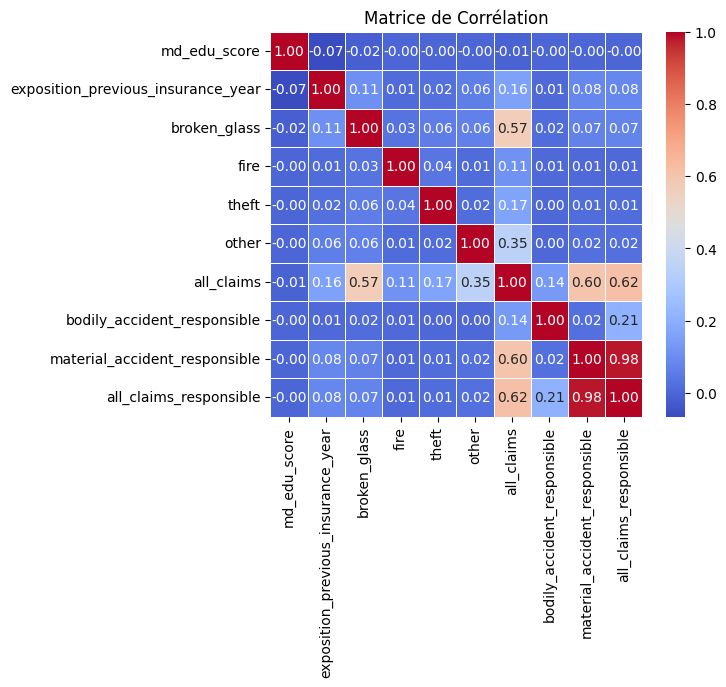

In [11]:
base_corr=base.drop(["facteur1","facteur2","facteur3"], axis=1)
base_corr.columns=["md_edu_score","exposition_previous_insurance_year","broken_glass","fire","theft","other","all_claims","bodily_accident_responsible","material_accident_responsible","all_claims_responsible"]
corr_matrix=base_corr.corr()
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

Bien que la variable var_Assurance15 (all_claims_responsible) est tres fortement correlée avec la variable var_Assurance10("material_accident_responsible") cela ne pourrait entrainer un problème de multicolinéarité dans le modèle car il est basé sur des arbres de décision. 

In [12]:
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(base, bodily, test_size=0.3, stratify=bodily, random_state=40)
#x_train = scaler.fit_transform(x_train)
y_train.value_counts()

var_Assurance2
0    46391
1      279
2       13
3        2
Name: count, dtype: int64

In [37]:


# Calcul de la variance de chaque ligne pour var_Assurance2
variance_var_assu2 = bodily.var()

# Calcul de la moyenne de var_Assurance2
mean_var_assu2 = bodily.mean()

# Afficher les résultats
print(f"Variance de var_Assurance2 : {variance_var_assu2}")
print(f"Moyenne de var_Assurance2 : {mean_var_assu2}")

# Comparaison
if variance_var_assu2 > mean_var_assu2:
    print("La variance est supérieure à la moyenne.")
elif variance_var_assu2 < mean_var_assu2:
    print("La moyenne est supérieure à la variance.")
else:
    print("La variance et la moyenne sont égales.")

Variance de var_Assurance2 : 0.007348069143468633
Moyenne de var_Assurance2 : 0.006642376261376756
La variance est supérieure à la moyenne.


Puisque la variance de Bodily est supérieure à sa moyenne, nous pouvons envisager ajuster le modèle avec une binomiale négative

<h3>Prédiction de bodily(var_Assurance2)</h3>

In [ ]:
!pip install xgboost

In [15]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Supposons que `base` soit déjà nettoyé et prêt à l'emploi
# On va entraîner XGBoost pour prédire `bodily`
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Entraînement XGBoost
xgb_model.fit(x_train, y_train)

# Extraire les prédictions ou probabilités comme features
xgb_features_train = xgb_model.predict_proba(x_train)
xgb_features_test = xgb_model.predict_proba(x_test)


c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:21:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

# Supposons que tu as déjà entraîné ton modèle XGBoost :
# model_xgb.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = xgb_model.predict(x_test)

# Accuracy globale
print("Accuracy :", accuracy_score(y_test, y_pred))

# Classification report
print("Classification Report :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


Accuracy : 0.9975509796081568
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19882
           1       0.93      0.64      0.76       120
           2       1.00      0.17      0.29         6

    accuracy                           1.00     20008
   macro avg       0.98      0.60      0.68     20008
weighted avg       1.00      1.00      1.00     20008

Matrice de confusion :
[[19881     1     0]
 [   43    77     0]
 [    0     5     1]]


<p>
le modèle est parfait pour la classe 0 <br/>
1 prédiction sur 3 est fausse pour la classe 1<br/>
2 prédictions sur 3 sont fausses pour la classe 2
</p>

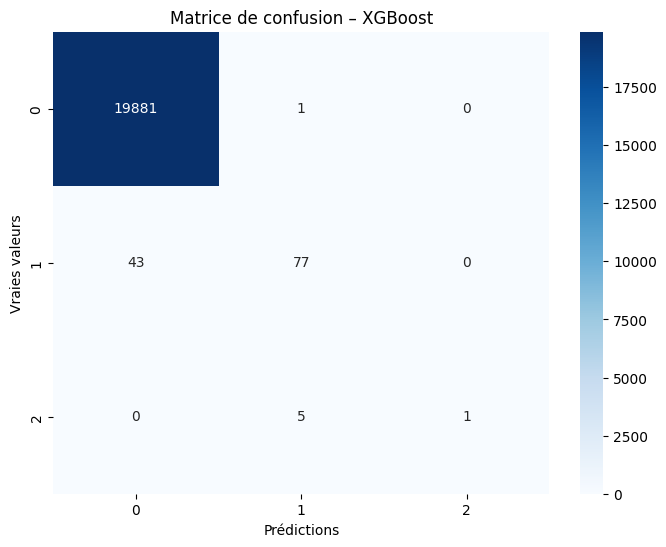

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
labels = sorted(set(y_test))  # pour s'assurer que les classes soient bien ordonnées

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion – XGBoost')
plt.show()


Le modèle xgboost construit est très performant(accuracy =0.98) pour predire la classe 0 mais moins sur les autres classe à cause du déséquilibre des classes , nous allons appliquer un GLM à ces sorties afin de réduire le biais due au déséquilibre des classes.

In [38]:


# Calcul de la variance de chaque ligne pour var_Assurance2
variance_var_assu2 = bodily.var()

# Calcul de la moyenne de var_Assurance2
mean_var_assu2 = bodily.mean()

# Afficher les résultats
print(f"Variance de var_Assurance2 : {variance_var_assu2}")
print(f"Moyenne de var_Assurance2 : {mean_var_assu2}")

# Comparaison
if variance_var_assu2 > mean_var_assu2:
    print("La variance est supérieure à la moyenne.")
elif variance_var_assu2 < mean_var_assu2:
    print("La moyenne est supérieure à la variance.")
else:
    print("La variance et la moyenne sont égales.")

Variance de var_Assurance2 : 0.007348069143468633
Moyenne de var_Assurance2 : 0.006642376261376756
La variance est supérieure à la moyenne.


In [ ]:
!pip install statsmodels

### application d'un modèle multinomiale aux sorties du modèle XGBoost

In [53]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
import pandas as pd

# Ajouter une constante (interception) à l'entrée du GLM
xgb_train_glm = sm.add_constant(xgb_features_train)
xgb_test_glm = sm.add_constant(xgb_features_test)

# Modèle multinomial (multiclasse)
glm_model = MNLogit(y_train, xgb_train_glm)
glm_result = glm_model.fit()

# Résumé statistique du modèle
print(glm_result.summary())

# Prédictions
y_pred_probs = glm_result.predict(xgb_test_glm)
y_pred = np.argmax(y_pred_probs, axis=1)



c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\discrete\discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\discrete\discrete_model.py:3028: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 17
                          MNLogit Regression Results                          
Dep. Variable:         var_Assurance2   No. Observations:                46685
Model:                        MNLogit   Df Residuals:                    46670
Method:                           MLE   Df Model:                           12
Date:                Thu, 10 Apr 2025   Pseudo R-squ.:                     nan
Time:                        12:21:15   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -1848.1
Covariance Type:            nonrobust   LLR p-value:                       nan
var_Assurance2=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                   nan        nan        nan        nan         nan         nan
x1             

In [54]:

# Évaluation
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19882
           1       0.00      0.00      0.00       120
           2       0.00      0.00      0.00         6

    accuracy                           0.99     20008
   macro avg       0.33      0.33      0.33     20008
weighted avg       0.99      0.99      0.99     20008



c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<p>
le modèle s'est éfondré et ne prédit que la première classe désormais
</p>
<br/>

### application d'une regression logistique avec pondération des classes

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Entraînement du GLM avec class_weight='balanced'
glm_model1 = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=40,
    class_weight='balanced'
)

# Fit sur les features issues de XGBoost
glm_model1.fit(xgb_features_train, y_train)

# Prédictions (classes directement)
y_pred1 = glm_model1.predict(xgb_features_test)

# Évaluation
print("Classification Report :")
print(classification_report(y_test, y_pred1))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred1))


c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19882
           1       0.93      0.64      0.76       120
           2       1.00      0.17      0.29         6

    accuracy                           1.00     20008
   macro avg       0.98      0.60      0.68     20008
weighted avg       1.00      1.00      1.00     20008

Matrice de confusion :
[[19881     1     0]
 [   43    77     0]
 [    0     5     1]]


le modèle prédit des valeurs positives représentant des comptages attendus.
Le modèle prédit très mal les classes déséquilibrés.

### Application d'une regression(GLM binomial négatif) aux sorties de XGBoost

In [ ]:

# Évaluation
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1))

In [41]:
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
# Ajout de constante (intercept)
xgb_train_glm = sm.add_constant(xgb_features_train)
xgb_test_glm = sm.add_constant(xgb_features_test)

# GLM multinomial (famille Binomial pour classification binaire, ou multinomiale si besoin)
glm_model = sm.GLM(y_train, xgb_train_glm, family=NegativeBinomial())

glm_result = glm_model.fit()

# Résumé du modèle
print(glm_result.summary())

# Prédictions
pred_probs = glm_result.predict(xgb_test_glm)
pred_classes = (pred_probs > 0.5).astype(int)  # ou np.argmax() pour multi-classes


c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:         var_Assurance2   No. Observations:                46685
Model:                            GLM   Df Residuals:                    46680
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -496.97
Date:                Thu, 10 Apr 2025   Deviance:                       161.74
Time:                        11:47:42   Pearson chi2:                     365.
No. Iterations:                     9   Pseudo R-squ. (CS):            0.05715
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.921e+05   2.15e+06      0.089      0.9

In [44]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Prédictions continues
y_pred = glm_result.predict(xgb_test_glm)

# Évaluation
print("R² :", r2_score(y_test, y_pred))
print("RMSE(ecart-type) :", np.sqrt(mean_squared_error(y_test, y_pred)))  # remplacement ici
print("MAE(variance) :", mean_absolute_error(y_test, y_pred))


R² : 0.41744600456543257
RMSE(ecart-type) : 0.06455506114227136
MAE(variance) : 0.005275955698361583


ce modèle semble produire de bons résultats mais n'est pas adapté pour une prédiction de variables catégorielles car c'est une regression , donc les sorties ne seront pas toujours entières. Nous allons donc opter pour un modèle de classification multiclasse(MNLogit)

<b>
Puisque nous n'arrivons à améliorer la précision du modèle xgboost, nous allons faire un reéchantillonnage avant les prédictions
</b>

### Utisation du modèle après reéchantillonnage rééchantillonage SMOTE

In [58]:
from sklearn.model_selection import StratifiedShuffleSplit
#Création du split en respectant les proportions des classes
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=40)

for train_index, test_index in sss.split(base, bodily):
    X_train, X_test = base.iloc[train_index], base.iloc[test_index]
    y_train, y_test = bodily.iloc[train_index], bodily.iloc[test_index]

#Vérification de la distribution des classes
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

var_Assurance2
0    0.993702
1    0.005979
2    0.000281
3    0.000037
Name: proportion, dtype: float64
var_Assurance2
0    0.993703
1    0.005997
2    0.000300
Name: proportion, dtype: float64


### **Prédiction du risque matériel(var_Assurance3)** 

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
x_train2, x_test2, y_train2, y_test2 = train_test_split(base, material, test_size=0.3, stratify=material, random_state=40)
#x_train = scaler.fit_transform(x_train)
y_train2.value_counts()

In [ ]:


# Calcul de la variance de chaque ligne pour var_Assurance2
variance_var_assu3 = material.var()

# Calcul de la moyenne de var_Assurance2
mean_var_assu3 = material.mean()

# Afficher les résultats
print(f"Variance de var_Assurance3 : {variance_var_assu3}")
print(f"Moyenne de var_Assurance3 : {mean_var_assu3}")

# Comparaison
if variance_var_assu2 > mean_var_assu2:
    print("La variance est supérieure à la moyenne.")
elif variance_var_assu2 < mean_var_assu2:
    print("La moyenne est supérieure à la variance.")
else:
    print("La variance et la moyenne sont égales.")

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Supposons que `base` soit déjà nettoyé et prêt à l'emploi
# On va entraîner XGBoost pour prédire `bodily`
xgb_model2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Entraînement XGBoost
xgb_model2.fit(x_train2, y_train2)

# Extraire les prédictions ou probabilités comme features
xgb_features_train2 = xgb_model2.predict_proba(x_train2)
xgb_features_test2 = xgb_model2.predict_proba(x_test2)


<br/>
<br/>

<h2 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u> Implémentation d'une regression logistique (deeson)</u></h2>
<br/>
    